# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #2:
- Task 1: Dependencies and OpenAI API Key
- Task 2: LCEL RAG Chain
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset
- Task 6: Evaluation

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for a simple RAG system built on top of LangChain's blogs!

In [63]:
%pip install langchain_core langchain_openai langchain_community langchain-qdrant qdrant-client langsmith openai tiktoken cohere lxml -qU

Note: you may need to restart the kernel to use updated packages.


In [64]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

#gets key for privacy access

#### Asyncio Bug Handling

This is necessary for Colab.

In [65]:
import nest_asyncio
nest_asyncio.apply()

#allows running of async code in an existing loop

## Task #2: Create a Simple RAG Application Using Qdrant, Hugging Face, and LCEL

Now that we have a grasp on how LCEL works, and how we can use LangChain and Hugging Face to interact with our data - let's step it up a notch and incorporate Qdrant!

## LangChain Powered RAG

First and foremost, LangChain provides a convenient way to store our chunks and their embeddings.

It's called a `VectorStore`!

We'll be using QDrant as our `VectorStore` today. You can read more about it [here](https://qdrant.tech/documentation/).

Think of a `VectorStore` as a smart way to house your chunks and their associated embedding vectors. The implementation of the `VectorStore` also allows for smarter and more efficient search of our embedding vectors - as the method we used above would not scale well as we got into the millions of chunks.

Otherwise, the process remains relatively similar under the hood!

We'll use a SiteMapLoader to scrape the LangChain blogs - which will serve as our data for today!

### Data Collection

We'll be leveraging the `SitemapLoader` to load our PDF directly from the web!

In [66]:
%pip install bs4

#had to install bs4 due to error

Note: you may need to restart the kernel to use updated packages.


In [67]:

from langchain.document_loaders import SitemapLoader

documents = SitemapLoader(web_path="https://blog.langchain.dev/sitemap-posts.xml").load()

#loads web path for content

Fetching pages: 100%|##########| 220/220 [00:39<00:00,  5.62it/s]


### Chunking Our Documents

Let's do the same process as we did before with our `RecursiveCharacterTextSplitter` - but this time we'll use ~200 tokens as our max chunk size!

In [68]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 0,
    length_function = len,
)

split_chunks = text_splitter.split_documents(documents)

#splits text into chunks of approx 500 tokens

In [69]:
len(split_chunks)

#returns number of chunks

4821

Alright, now we have 516 ~200 token long documents.

Let's verify the process worked as intended by checking our max document length.

In [70]:
max_chunk_length = 0

for chunk in split_chunks:
  max_chunk_length = max(max_chunk_length, len(chunk.page_content))

print(max_chunk_length)

#returns the largest chunk (capped at 500)

499


Perfect! Now we can carry on to creating and storing our embeddings.

### Embeddings and Vector Storage

We'll use the `text-embedding-3-small` embedding model again - and `Qdrant` to store all our embedding vectors for easy retrieval later!

In [71]:
from langchain_community.vectorstores import Qdrant
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

qdrant_vectorstore = Qdrant.from_documents(
    documents=split_chunks,
    embedding=embedding_model,
    location=":memory:"
)

#uses Qdrant to embed vectors, stores embeddings for later query

Now let's set up our retriever, just as we saw before, but this time using LangChain's simple `as_retriever()` method!

In [72]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

#converts the vector store from above into an easily retrieved format

#### Back to the Flow

We're ready to move to the next step!

### Setting up our RAG

We'll use the LCEL we touched on earlier to create a RAG chain.

Let's think through each part:

1. First we need to retrieve context
2. We need to pipe that context to our model
3. We need to parse that output

Let's start by setting up our prompt again, just so it's fresh in our minds!

####🏗️ Activity #2:

Complete the prompt so that your RAG application answers queries based on the context provided, but *does not* answer queries if the context is unrelated to the query.

In [73]:
from langchain.prompts import ChatPromptTemplate

base_rag_prompt_template = """\
Answer the questions only based on context provided.

Do not answer questions unrelated to the context

Context:
{context}

Question:
{question}
"""

base_rag_prompt = ChatPromptTemplate.from_template(base_rag_prompt_template)

#RAG to answer questions only on the context in the {context} variable

We'll set our Generator - `gpt-4o` in this case - below!

In [74]:
from langchain_openai.chat_models import ChatOpenAI

base_llm = ChatOpenAI(model="gpt-4o-mini", tags=["base_llm"])

#set llm to gpt-4o

#### Our RAG Chain

Notice how we have a bit of a more complex chain this time - that's because we want to return our sources with the response.

Let's break down the chain step-by-step:

1. We invoke the chain with the `question` item. Notice how we only need to provide `question` since both the retreiver and the `"question"` object depend on it.
  - We also chain our `"question"` into our `retriever`! This is what ultimately collects the context through Qdrant.
2. We assign our collected context to a `RunnablePassthrough()` from the previous object. This is going to let us simply pass it through to the next step, but still allow us to run that section of the chain.
3. We finally collect our response by chaining our prompt, which expects both a `"question"` and `"context"`, into our `llm`. We also, collect the `"context"` again so we can output it in the final response object.

The key thing to keep in mind here is that we need to pass our context through *after* we've retrieved it - to populate the object in a way that doesn't require us to call it or try and use it for something else.

In [75]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": base_rag_prompt | base_llm, "context": itemgetter("context")}
)

Let's get a visual understanding of our chain!

In [76]:
%pip install -qU grandalf

Note: you may need to restart the kernel to use updated packages.


In [77]:
print(retrieval_augmented_qa_chain.get_graph().draw_ascii())

#ascii art for workflow

          +---------------------------------+      
          | Parallel<context,question>Input |      
          +---------------------------------+      
                    **            **               
                  **                **             
                **                    **           
         +--------+                     **         
         | Lambda |                      *         
         +--------+                      *         
              *                          *         
              *                          *         
              *                          *         
  +----------------------+          +--------+     
  | VectorStoreRetriever |          | Lambda |     
  +----------------------+          +--------+     
                    **            **               
                      **        **                 
                        **    **                   
          +----------------------------------+     
          | 

Let's try another visual representation:

![image](https://i.imgur.com/Ad31AhL.png)

Let's test our chain out!

In [78]:
response = retrieval_augmented_qa_chain.invoke({"question" : "What's new in LangChain v0.2?"})

#ask related question

In [79]:
response["response"].content

#print answer

'LangChain v0.2 introduces several new features, including:\n\n1. Full separation of langchain and langchain-community.\n2. New and versioned documentation.\n3. A more mature and controllable agent framework.\n4. Improved standardization of the LLM interface, particularly around tool calling.\n5. Streaming support.\n6. Over 30 new partner packages.\n\nThis pre-release focuses on improving stability and security, with a full release expected in a few weeks.'

In [80]:
for context in response["context"]:
  print("Context:")
  print(context)
  print("----")
#print context

Context:
page_content='Four months ago, we released the first stable version of LangChain. Today, we are following up by announcing a pre-release of langchain v0.2.This release builds upon the foundation laid in v0.1 and incorporates community feedback. We’re excited to share that v0.2 brings: A much-desired full separation of langchain and langchain-community New (and versioned!) docs A more mature and controllable agent framework Improved LLM interface standardization, particularly around tool callingBetter' metadata={'source': 'https://blog.langchain.dev/langchain-v02-leap-to-stability/', 'loc': 'https://blog.langchain.dev/langchain-v02-leap-to-stability/', 'lastmod': '2024-05-16T22:26:07.000Z', '_id': '728c4b9e996449e493927d08ea16952d', '_collection_name': 'b9624d774d454c66ad3f37cd877b56ab'}
----
Context:
page_content='LangChain v0.2: A Leap Towards Stability




















































Skip to content
















All Posts




Case Studies




In the Lo

Let's see if it can handle a query that is totally unrelated to the source documents.

In [81]:
response = retrieval_augmented_qa_chain.invoke({"question" : "What is the airspeed velocity of an unladen swallow?"})

In [82]:
response["response"].content

#does not talk about Monty Python reference since it does not apply to the context

'The context provided does not contain information related to the airspeed velocity of an unladen swallow.'

## Task 3: Setting Up LangSmith

Now that we have a chain - we're ready to get started with LangSmith!

We're going to go ahead and use the following `env` variables to get our Colab notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [83]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

#generates LangSmith unique ID

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"LangSmith - {unique_id}"

#sets project associated with unique ID

### LangSmith API

In order to use LangSmith - you will need a beta key, you can join the queue through the `Beta Sign Up` button on LangSmith's homepage!

Join [here](https://www.langchain.com/langsmith)

In [84]:
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

#permissions, asks for API Key

Let's test our our first generation!

In [85]:
retrieval_augmented_qa_chain.invoke({"question" : "What is LangSmith?"}, {"tags" : ["Demo Run"]})['response']

#triggers chain with arguments

AIMessage(content='LangSmith is a framework built on the shoulders of LangChain, designed to track various aspects of AI-powered products. It provides features for observability and customizability, particularly through its SDK, which allows users to implement fine-grain controls in their LLM-related functions.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 907, 'total_tokens': 962}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-ebb14ede-7553-4069-be19-9282ac46d3a4-0', usage_metadata={'input_tokens': 907, 'output_tokens': 55, 'total_tokens': 962})

## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.

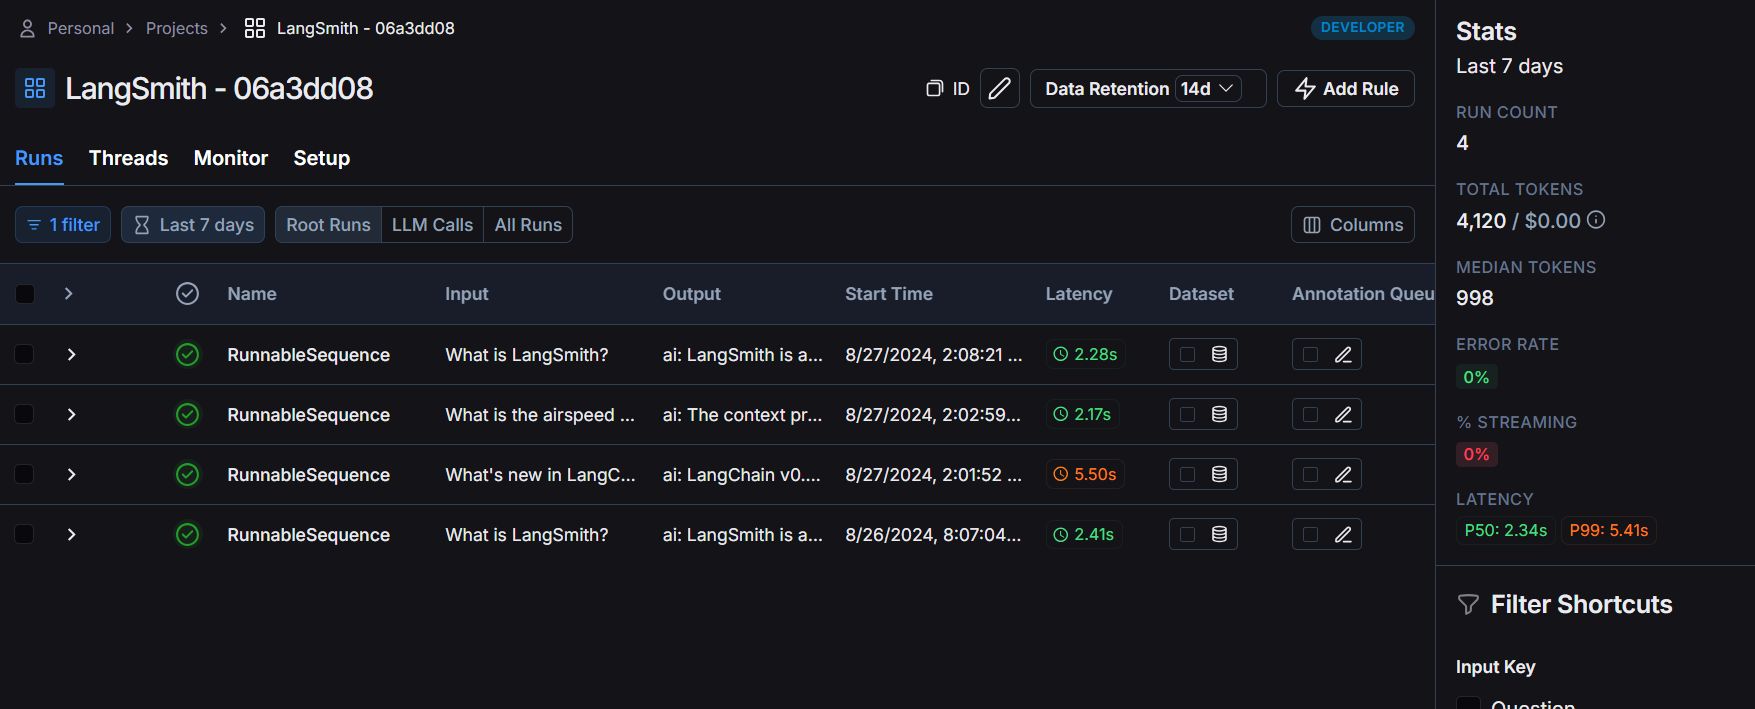

In [ ]:
#this is a collection of runs relating to this project
#the project is separated by the 8 digit code made in the cell [34]
#shows each time the project was run, input, output, and duration

## Task 5: Loading Our Testing Set

In [60]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

fatal: destination path 'DataRepository' already exists and is not an empty directory.


In [86]:
import pandas as pd

test_df = pd.read_csv("DataRepository/langchain_blog_test_data.csv")

#loads .csv as text for testing

Now we can set up our LangSmith client - and we'll add the above created dataset to our LangSmith instance!

> NOTE: Read more about this process [here](https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets#create-from-list-of-values)

In [88]:
from langsmith import Client

client = Client()

dataset_name = "langsmith-demo-dataset-aie4-triples-v3_1" #had to change name to get it to run again

dataset = client.create_dataset(
    dataset_name=dataset_name, description="LangChain Blog Test Questions"
)

for triplet in test_df.iterrows():
  triplet = triplet[1]
  client.create_example(
      inputs={"question" : triplet["question"], "context": triplet["context"]},
      outputs={"answer" : triplet["answer"]},
      dataset_id=dataset.id
  )

  #populates dataset in langsmith, framework to be used in test

## Task 6: Evaluation

Now we can run the evaluation!

We'll need to start by preparing some custom data preparation functions to ensure our chain works with the expected inputs/outputs from the `evaluate` process in LangSmith.

> NOTE: More reading on this available [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#evaluate-a-langchain-runnable)

In [89]:
def prepare_data_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.outputs["answer"],
      "input" : example.inputs["question"]
  }

def prepare_data_noref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "input" : example.inputs["question"]
  }

def prepare_context_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.inputs["context"],
      "input" : example.inputs["question"]
  }

#different functions that could compare outputs with references and inputs

We'll be using a few custom evaluators to evaluate our pipeline, as well as a few "built in" methods!

Check out the built-ins [here](https://docs.smith.langchain.com/reference/sdk_reference/langchain_evaluators)!

In [90]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

cot_qa_evaluator = LangChainStringEvaluator("cot_qa", prepare_data=prepare_context_ref)

unlabeled_dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria" : {
            "dopeness" : "Is the answer to the question dope, meaning cool - awesome - and legit?"
        }
    },
    prepare_data=prepare_data_noref
)

labeled_score_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": {
            "accuracy": "Is the generated answer the same as the reference answer?"
        },
    },
    prepare_data=prepare_data_ref
)

base_rag_results = evaluate(
    retrieval_augmented_qa_chain.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        ],
    experiment_prefix="Base RAG Evaluation"
)

#uses AI to compare the input and reference output
#purpose is to evaluate the performance of the RAG using LangChain evaluation tools

View the evaluation results for experiment: 'Base RAG Evaluation-e36b10e8' at:
https://smith.langchain.com/o/2f518fba-2c1b-5c4b-96c1-22f9cb267b88/datasets/cab678be-fff5-4ae5-bbe6-54f182d82c10/compare?selectedSessions=8a5b86a2-29c1-4806-98de-70aa0f302458




0it [00:00, ?it/s]Error running evaluator <DynamicRunEvaluator evaluate> on run 991b792f-7278-46e3-8d02-b8ae58deea59: RateLimitError("Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4 in organization org-NZObkZ2X3TjD1o28KIteLmzF on tokens per min (TPM): Limit 10000, Used 9952, Requested 365. Please try again in 1.902s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}")
Traceback (most recent call last):
  File "/home/jensen_e/anaconda3/envs/llmops-course/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1267, in _run_evaluators
    else:
          
  File "/home/jensen_e/anaconda3/envs/llmops-course/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/home/jensen_e/anaconda3/envs/llmops-course/lib/python3.11/site-packages/langsmith/run_helpers.py", line 609, in wrapper


#### ❓Question #1:

What conclusions can you draw about the above results?

Describe in your own words what the metrics are expressing.

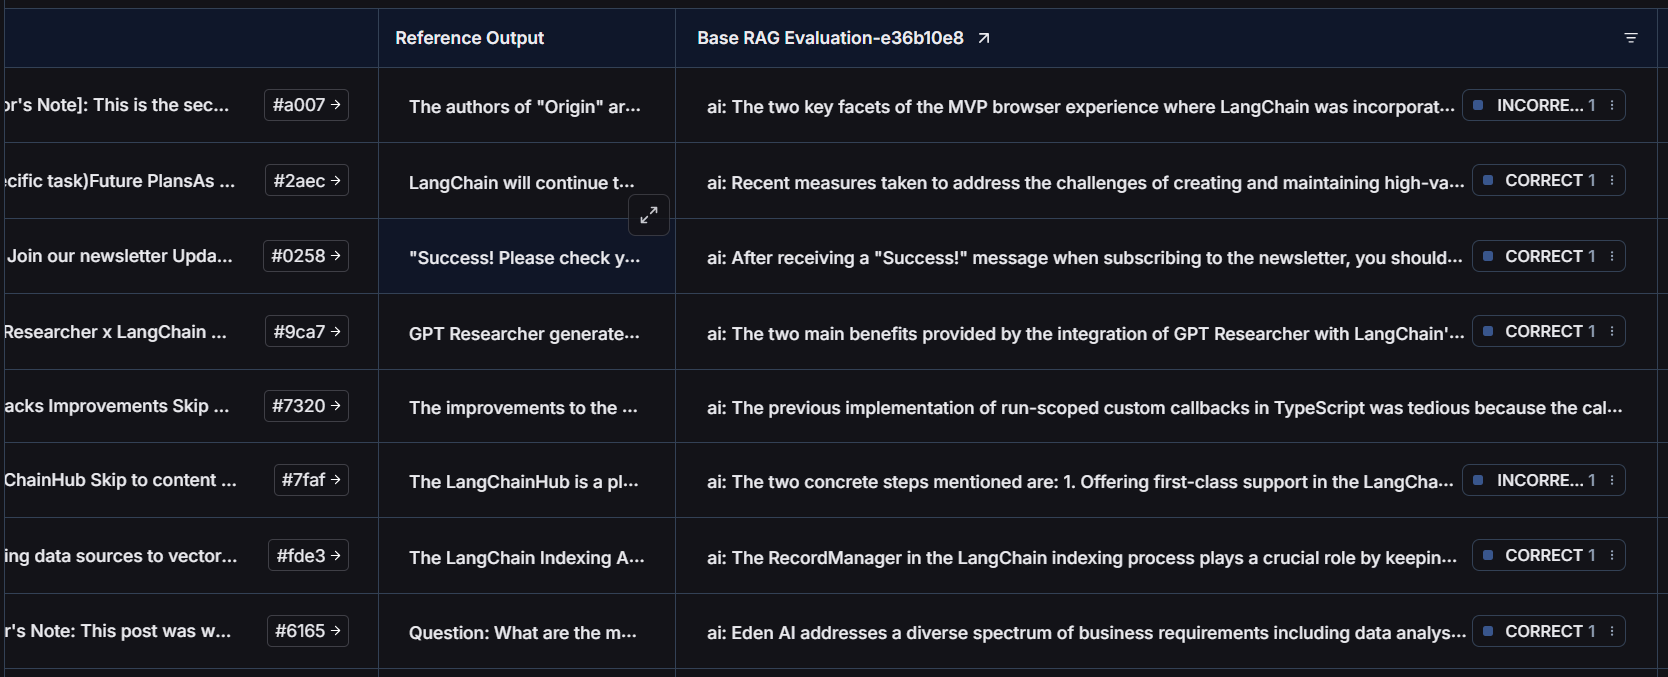

It looks like the comparison was overall pretty good. two of the tests came back as inaccurate, but the others were "approved" by AI
The two that were marked as inaccurate show that the RAG didn't return an output similar enough to the input, and reading through the two, AI output and the reference output were very different.